In [2]:
from goatools.obo_parser import GODag
from goatools.gosubdag.gosubdag import GoSubDag
#from matplotlib import matplotlib_venn
from plotnine import * 


# Interactive RLIPP Calculation

This notebook helps you interactively work through RLIPP (Relative Local Improvement in Predictive Power) calculation with your trained model.


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add model directory to path to import modules
sys.path.append(os.path.join(os.getcwd(), 'model'))

# Import modules from model directory
from data_wrapper import TrainingDataWrapper
import prepare_dataloader
import utils
from calculate_rlipp import RLIPPCalculator


## Configuration

Set up paths and parameters for RLIPP calculation


In [4]:
# Paths to required files
MODEL_PATH = "MODEL-jc/202510141833_model.pt"
ONTOLOGY_FILE = "filtered/filtered_ontology.txt"
GENE2ID_FILE = "filtered/filtered_gene2id.txt"
TEST_DATA = "filtered/test.pt"

# Parameters (should match training configuration)
GENOTYPE_HIDDENS = 50      # Number of hidden neurons per term
MIN_DROPOUT_LAYER = 2      # Minimum layer for dropout
DROPOUT_FRACTION = 0.1     # Dropout fraction
BATCHSIZE = 64             # Batch size for inference
PREDICTOR_EPOCHS = 100     # Epochs to train predictor for each term


## Load the Trained Model

Load the model and check its structure


In [5]:

device = torch.device("cpu")

model = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.eval()

print(f"Model has {len(model.term_layer_list)} layers")
print(f"Root term: {model.root}")


Model has 6 layers
Root term: ROOT


## Explore Model Structure

Let's examine the structure of the model to better understand what we're working with


In [6]:
for i, layer in enumerate(model.term_layer_list):
    print(i)
    print(len(layer))

0
184
1
111
2
48
3
21
4
12
5
1


In [7]:
for i, layer in enumerate(model.term_layer_list):
    print(f"Layer {i}: {len(layer)} terms")


Layer 0: 184 terms
Layer 1: 111 terms
Layer 2: 48 terms
Layer 3: 21 terms
Layer 4: 12 terms
Layer 5: 1 terms


## Create Data Wrapper

Set up the data wrapper for loading test data


In [8]:
# Create a minimal args object for data wrapper
class MinimalArgs:
    pass

minimal_args = MinimalArgs()
minimal_args.gene2id = GENE2ID_FILE
minimal_args.onto = ONTOLOGY_FILE
minimal_args.genotype_hiddens = GENOTYPE_HIDDENS
minimal_args.min_dropout_layer = MIN_DROPOUT_LAYER
minimal_args.dropout_fraction = DROPOUT_FRACTION
minimal_args.lr = 0.001  # Not used for RLIPP
minimal_args.wd = 0.0001  # Not used for RLIPP
minimal_args.alpha = 0.1  # Not used for RLIPP
minimal_args.epoch = 1  # Not used for RLIPP
minimal_args.batchsize = BATCHSIZE
minimal_args.modeldir = './'  # Not used for RLIPP
minimal_args.delta = 0.01  # Not used for RLIPP
minimal_args.train = TEST_DATA  # Use test as train (we just need the structure)
minimal_args.test = TEST_DATA
minimal_args.testsetratio = 0.0
minimal_args.optimize = 1
minimal_args.metric_output = 'temp.tsv'

# Create data wrapper
data_wrapper = TrainingDataWrapper(minimal_args, logger=None)


Total number of genes = 574


## Load Test Data

Load the test data for RLIPP calculation


In [9]:
# Load test data
print(f"Loading test data from: {TEST_DATA}")
_, test_loader = prepare_dataloader.get_from_pt(TEST_DATA, TEST_DATA, BATCHSIZE)

# Examine test data
for batch_idx, (data, target) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Data shape: {data.shape}, Target shape: {target.shape}")
    print(f"Data type: {data.dtype}, Target type: {target.dtype}")
    print(f"Data sample: {data[0][:5]}...")
    print(f"Target sample: {target[0]}")
    break  # Just examine the first batch


Loading test data from: filtered/test.pt
Batch 0: Data shape: torch.Size([64, 574]), Target shape: torch.Size([64])
Data type: torch.int8, Target type: torch.float32
Data sample: tensor([1, 3, 2, 2, 2], dtype=torch.int8)...
Target sample: 1.3397338390350342


## Initialize RLIPP Calculator

Create the RLIPP calculator object


In [10]:
# Create RLIPP calculator
calculator = RLIPPCalculator(model, data_wrapper, device, predictor_epochs=PREDICTOR_EPOCHS)


In [20]:
rlipp_scores = calculator.calculate_rlipp_scores(test_loader)


Extracting embeddings from model...
Processing batch 1/1250
Processing batch 2/1250
Processing batch 3/1250
Processing batch 4/1250
Processing batch 5/1250
Processing batch 6/1250
Processing batch 7/1250
Processing batch 8/1250
Processing batch 9/1250
Processing batch 10/1250
Processing batch 11/1250
Processing batch 12/1250
Processing batch 13/1250
Processing batch 14/1250
Processing batch 15/1250
Processing batch 16/1250
Processing batch 17/1250
Processing batch 18/1250
Processing batch 19/1250
Processing batch 20/1250
Processing batch 21/1250
Processing batch 22/1250
Processing batch 23/1250
Processing batch 24/1250
Processing batch 25/1250
Processing batch 26/1250
Processing batch 27/1250
Processing batch 28/1250
Processing batch 29/1250
Processing batch 30/1250
Processing batch 31/1250
Processing batch 32/1250
Processing batch 33/1250
Processing batch 34/1250
Processing batch 35/1250
Processing batch 36/1250
Processing batch 37/1250
Processing batch 38/1250
Processing batch 39/125

In [12]:
df = pd.DataFrame(rlipp_scores).transpose().reset_index(names='term')
max(df.rlipp)

1.8334889243697774

In [13]:
# Import the functions from your obo_parser module
from model.obo_parser import parse_obo_file, create_term_name_dict

# Path to your OBO file
obo_file = "GO/go-basic.obo"  # Adjust path as needed

# 1. Parse the OBO file to get all term information
terms = parse_obo_file(obo_file)
godf = pd.DataFrame(terms).transpose()
godf
df = df.merge(godf, left_on = 'term', right_on = 'id')
df

,term,rlipp,term_power,children_power,num_children,layer,id,name,namespace,definition,is_obsolete,parents
0,GO:0006631,0.011003,0.011003,0.000000,0.0,0.0,GO:0006631,fatty acid metabolic process,biological_process,The chemical reactions and pathways involving ...,False,"[GO:0006629, GO:0032787]"
1,GO:0016567,0.023951,0.023951,0.000000,0.0,0.0,GO:0016567,protein ubiquitination,biological_process,The process in which one or more ubiquitin gro...,False,[GO:0032446]
2,GO:0006869,0.024125,0.024125,0.000000,0.0,0.0,GO:0006869,lipid transport,biological_process,"The directed movement of lipids into, out of o...",False,[GO:0006810]
3,GO:0010629,0.054020,0.054020,0.000000,0.0,0.0,GO:0010629,negative regulation of gene expression,biological_process,"Any process that decreases the frequency, rate...",False,"[GO:0010468, GO:0010558]"
4,GO:0046942,0.016797,0.016797,0.000000,0.0,0.0,GO:0046942,carboxylic acid transport,biological_process,The directed movement of carboxylic acids into...,False,"[GO:0015711, GO:0015849]"
...,...,...,...,...,...,...,...,...,...,...,...,...
371,GO:0009893,0.242241,0.134397,0.101841,1.0,4.0,GO:0009893,positive regulation of metabolic process,biological_process,Any process that activates or increases the fr...,False,"[GO:0019222, GO:0048522]"
372,GO:0010646,0.153282,0.134553,0.113928,1.0,4.0,GO:0010646,regulation of cell communication,biological_process,"Any process that modulates the frequency, rate...",False,[GO:0050794]
373,GO:0048583,-0.520956,0.052675,0.109959,1.0,4.0,GO:0048583,regulation of response to stimulus,biological_process,"Any process that modulates the frequency, rate...",False,[GO:0050789]
374,GO:0023051,-0.132891,0.106118,0.122381,1.0,4.0,GO:0023051,regulation of signaling,biological_process,"Any process that modulates the frequency, rate...",False,[GO:0050789]


/var/folders/c6/r1wdgpkd0njdj85b2jb0cj6w0000gn/T/ipykernel_58361/763837317.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/c6/r1wdgpkd0njdj85b2jb0cj6w0000gn/T/ipykernel_58361/763837317.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowpro

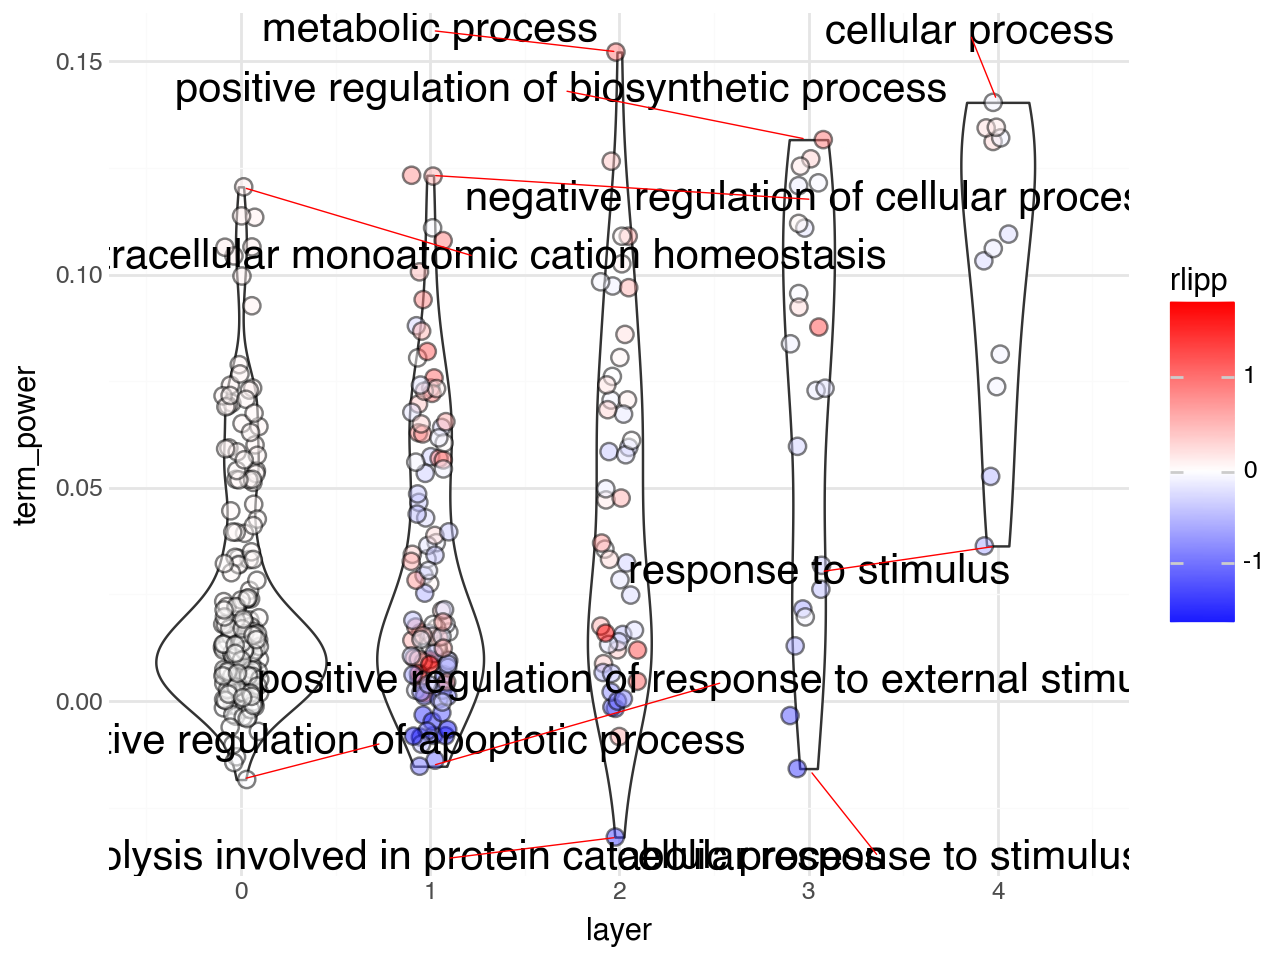

In [14]:
Top = df.groupby('layer', group_keys=False).apply(lambda g: g.nlargest(1, 'term_power'))
Bot = df.groupby('layer', group_keys=False).apply(lambda g: g.nsmallest(1, 'term_power'))

lab = pd.concat([Top, Bot]).sort_values(['layer', 'term_power'], ascending=[True, False])

lab = lab.loc[(lab['id'] != 'GO:0008150')]
lab

adjust_text_dict = {
    'force_text':1000,
 'expand_points': (50, 50),
    'force_explode': 10,
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'red'
    },
}
p =(ggplot(df, aes(x = 'layer', y = 'term_power', fill = "rlipp")) + 
    geom_violin(aes(group = 'layer')) + 
    geom_point(aes(group = 'layer'), position = position_jitter(width = 0.1), size = 3, alpha = 0.5) +
    scale_fill_gradient2(low = 'blue', mid = 'white', high = 'red', midpoint = 0) +
 geom_text(data = lab, mapping = aes(x = 'layer', y = 'term_power', label = 'name'), 
           adjust_text = adjust_text_dict,
           size = 15,
          color = 'black') +
 theme_minimal()
)
p
#p.save('rlipp.png', width = 8, height = 8)

## Extract Embeddings

Extract embeddings from the model for a small batch to examine


In [ ]:
# Create a small test loader with just one batch
for batch_idx, (data, target) in enumerate(test_loader):
    small_data = data[:10]  # Just use 10 samples
    small_target = target[:10]
    break
print(small_data.shape)
print(small_target.shape)

In [ ]:
# Create a simple dataloader with just this batch
from torch.utils.data import TensorDataset, DataLoader
small_dataset = TensorDataset(small_data, small_target)
small_loader = DataLoader(small_dataset, batch_size=10)


In [ ]:
# Extract embeddings
all_embeddings, all_labels = calculator.get_embeddings_and_labels(small_loader)

# Examine embeddings
print(f"Extracted embeddings for {len(all_embeddings)} terms")
print(f"Labels shape: {all_labels.shape}")

# Show example embedding shapes
print("\nExample embedding shapes:")
for i, (term, embedding) in enumerate(list(all_embeddings.items())[:5]):
    print(f"{term}: {embedding.shape}")

In [ ]:
for key in all_embeddings.keys():
    print(key)
    print(all_embeddings[key].shape)
    
    break


In [ ]:
model.term_layer_list

## Calculate RLIPP for a Single Term

Let's calculate RLIPP for a single term to understand the process


In [ ]:
# Pick a term from the middle layers (not root, not leaf)
middle_layer_idx = len(model.term_layer_list) // 2
example_term = model.term_layer_list[middle_layer_idx][0]  # First term in middle layer

print(f"Calculating RLIPP for term: {example_term}")

In [ ]:
# Get embedding for the term
term_embedding = all_embeddings[example_term]
print(f"Term embedding shape: {term_embedding.shape}")

# Get children of the term
children = model.term_neighbor_map[example_term]
print(f"Children: {children}")

In [ ]:
if children:
    # Concatenate children embeddings
    children_embeddings = [all_embeddings[child] for child in children]
    combined_children = torch.cat(children_embeddings, dim=1)
    print(f"Combined children embedding shape: {combined_children.shape}")
    
    # Calculate predictive power with term embedding
    term_power = calculator.calculate_predictive_power(term_embedding, all_labels, epochs=PREDICTOR_EPOCHS)
    
    # Calculate predictive power with only children embeddings
    children_power = calculator.calculate_predictive_power(combined_children, all_labels, epochs=PREDICTOR_EPOCHS)
    
    # Calculate RLIPP
    max_power = max(abs(term_power), abs(children_power))
    if max_power > 0:
        rlipp = (term_power - children_power) / max_power
    else:
        rlipp = 0.0
    
    print(f"Term power: {term_power:.4f}")
    print(f"Children power: {children_power:.4f}")
    print(f"RLIPP: {rlipp:.4f}")
else:
    print("This is a leaf node with no children.")

print('hi')


In [ ]:
pd.DataFrame(rlipp_scores).transpose().to_csv('rlipp.csv')

In [ ]:
ggplot(df, aes(x = 'rlipp')) + geom_histogram() + facet_wrap("~ layer", scales='free')

In [ ]:
for x in df.name.values:
    #print(x)
    if 'bmp' in x:
        print(x)


In [15]:
topr = df.sort_values('rlipp', ascending = False).head(20)
topr
#(ggplot(topr, aes(x='term', y = 'rlipp')) + geom_col())

,term,rlipp,term_power,children_power,num_children,layer,id,name,namespace,definition,is_obsolete,parents
340,GO:0002684,1.833489,0.015930,-0.013277,1.0,2.0,GO:0002684,positive regulation of immune system process,biological_process,Any process that activates or increases the fr...,False,"[GO:0002682, GO:0048518]"
265,GO:0032774,1.790016,0.008564,-0.006765,1.0,1.0,GO:0032774,RNA biosynthetic process,biological_process,The chemical reactions and pathways resulting ...,False,"[GO:0016070, GO:0141187]"
189,GO:0015711,1.705137,0.001694,-0.001194,1.0,1.0,GO:0015711,organic anion transport,biological_process,"The directed movement of organic anions into, ...",False,[GO:0006810]
241,GO:0070925,1.407661,0.009683,-0.003948,1.0,1.0,GO:0070925,organelle assembly,biological_process,"The aggregation, arrangement and bonding toget...",False,"[GO:0006996, GO:0022607]"
264,GO:0009615,1.395972,0.006436,-0.002549,1.0,1.0,GO:0009615,response to virus,biological_process,Any process that results in a change in state ...,False,[GO:0051707]
330,GO:0032101,1.292112,0.011965,-0.003495,1.0,2.0,GO:0032101,regulation of response to external stimulus,biological_process,"Any process that modulates the frequency, rate...",False,[GO:0048583]
345,GO:0006508,1.273427,0.087702,-0.023980,1.0,3.0,GO:0006508,proteolysis,biological_process,The hydrolysis of proteins into smaller polype...,False,[GO:0019538]
252,GO:1902533,1.165503,0.081975,-0.013567,1.0,1.0,GO:1902533,positive regulation of intracellular signal tr...,biological_process,Any process that activates or increases the fr...,False,"[GO:0009967, GO:1902531]"
304,GO:0003008,1.145999,0.004626,-0.000675,1.0,2.0,GO:0003008,system process,biological_process,A multicellular organismal process carried out...,False,[GO:0032501]
226,GO:0002682,1.070048,0.075768,-0.005307,1.0,1.0,GO:0002682,regulation of immune system process,biological_process,"Any process that modulates the frequency, rate...",False,[GO:0050789]


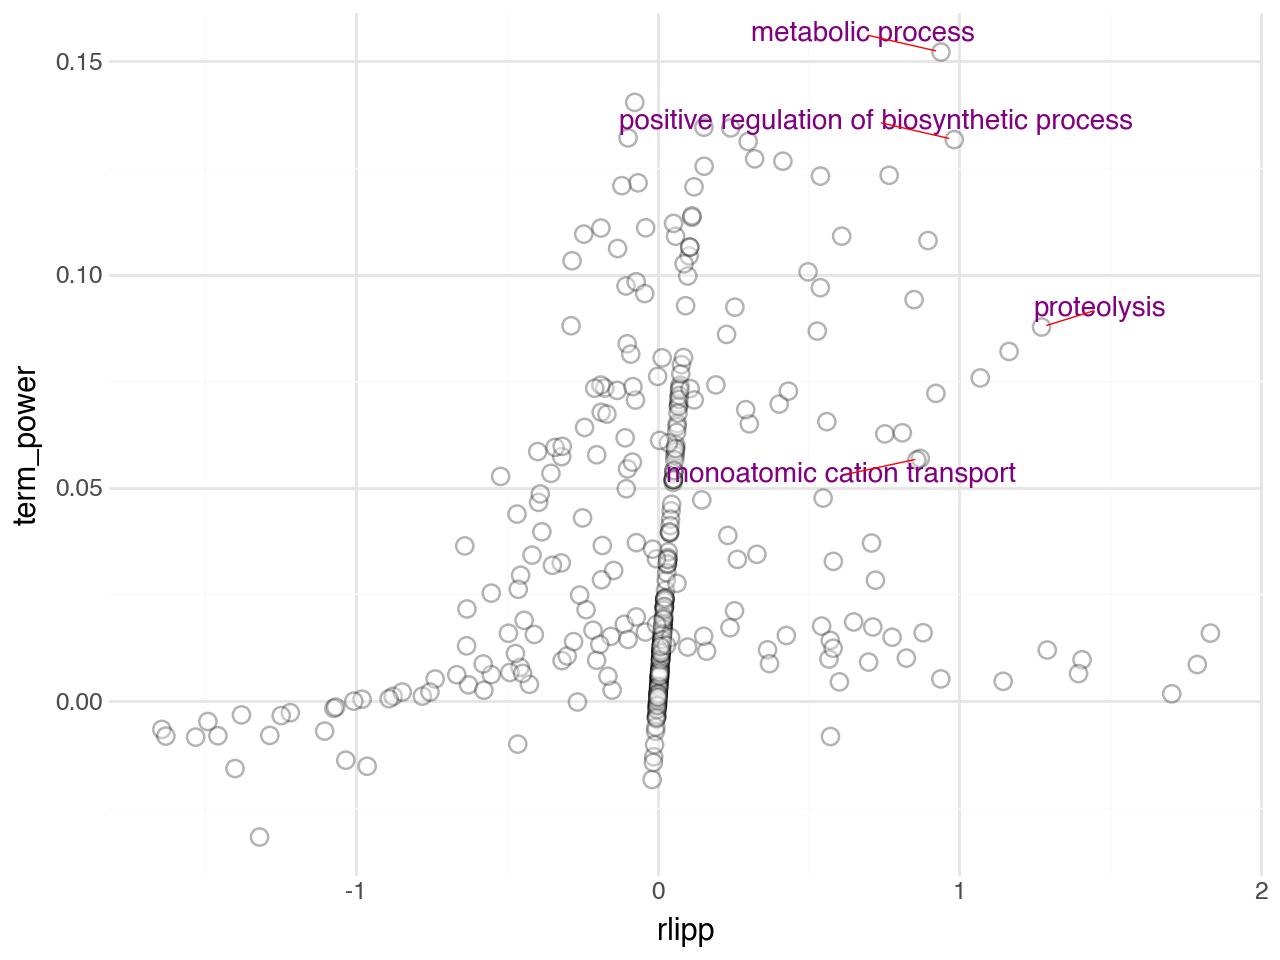

In [21]:
#Top = df.groupby('layer', group_keys=False).apply(lambda g: g.nlargest(1, 'term_power'))
#Bot = df.groupby('layer', group_keys=False).apply(lambda g: g.nsmallest(1, 'term_power'))
lab = df.sort_index(key = (df.term_power * df.rlipp).get, ascending=False).head(3)#'term_power','rlipp'], ascending = False).head(10)
cation = df[(df['name'] == 'monoatomic cation transport')]
#other = df[(df['name'] == 'BMP signalling pathway')]
lab = pd.concat([lab, cation, other])
#lab = pd.concat([Top, Bot]).sort_values(['layer', 'term_power'], ascending=[True, False])

adjust_text_dict = {
    'force_text':100,
 'expand_points': (5, 5),
 #   'force_explode': 2,
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'red'
    },
}
p =(ggplot(df, aes(x = 'rlipp', y = 'term_power')) + 
    #geom_violin(aes(group = 'layer')) + 
    geom_point(aes(group = 'layer'), 
               #position = position_jitter(width = 0.1), 
               size = 3, alpha = 0.3, fill= 'white') +
    #scale_fill_gradient2(low = 'blue', mid = 'white', high = 'red', midpoint = 0) +
 geom_text(data = lab, mapping = aes(x = 'rlipp', y = 'term_power', label = 'name'), 
          adjust_text = adjust_text_dict,
           size = 10,
          color = 'purple') +
 theme_minimal()
)
p
#p.save('rlipp_v_power.png', width = 5, height = 5)

In [ ]:

df

In [ ]:
Top = df.groupby('layer', group_keys=False).apply(lambda g: g.nlargest(1, 'rlipp'))
Bot = df.groupby('layer', group_keys=False).apply(lambda g: g.nsmallest(1, 'rlipp'))

lab = pd.concat([Top, Bot]).sort_values(['layer', 'rlipp'], ascending=[True, False])

lab = lab.loc[(lab['id'] != 'GO:0008150')]
lab

adjust_text_dict = {
    'force_text':10,
 'expand_points': (5, 5),
    'force_explode': 2,
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'red'
    },
}
p =(ggplot(df, aes(x = 'layer', y = 'rlipp', fill = "term_power")) + 
    geom_violin(aes(group = "layer")) + 
    geom_point(aes(group = "layer"), position = position_jitter(width = 0.1), size = 3, alpha = 0.5) +
    scale_fill_gradient2(low = 'blue', mid = 'white', high = 'red', midpoint = 0) +
 geom_text(data = lab, mapping = aes(x = 'layer', y = 'rlipp', label = 'name'), 
           adjust_text = adjust_text_dict,
           size = 15,
          color = 'black') +
 theme_minimal()
)
p
#p.save('rlipp_tp.png', width = 8, height = 8)

In [ ]:
# Visualize term connections with term_power coloring
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def visualize_term_connections(start_term, distance=2, figsize=(12, 10)):
    """
    Visualize terms connected to a specific start term with term_power coloring.
    
    Args:
        start_term: The term ID to start visualization from
        distance: Max distance from start term to include (default: 2)
        figsize: Figure size as (width, height) tuple
    """

    # Create graph from model structure
    G = nx.DiGraph()
    for term, children in model.term_neighbor_map.items():
        for child in children:
            G.add_edge(term, child)  # parent -> child
    
    # Get terms within specified distance
    connected_terms = set([start_term])
    current_terms = {start_term}
    
    # Explore both parents and children
    for _ in range(distance):
        next_terms = set()
        # Get children
        for term in current_terms:
            next_terms.update(list(G.successors(term)))
        # Get parents
        for term in current_terms:
            next_terms.update(list(G.predecessors(term)))
        
        connected_terms.update(next_terms)
        current_terms = next_terms

    # Extract subgraph
    subgraph = G.subgraph(connected_terms).copy()
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Try different layouts with more spacing for arrows
    try:
        # Use graphviz with spacing parameters
        pos = nx.nx_agraph.graphviz_layout(subgraph, prog='dot', args='-Gnodesep=0.5 -Granksep=1.0')
    except:
        # Increase k parameter to add more space between nodes
        pos = nx.spring_layout(subgraph, seed=42, k=1.2)
    
    # Get values from our dataframe
    rlipp_dict = dict(zip(df['term'], df['rlipp']))
    term_power_dict = dict(zip(df['term'], df['term_power']))
    
    # Prepare node attributes
    node_colors = []
    node_sizes = []
    node_labels = {}
    
    # Find min/max values for color scaling (term_power)
    term_powers = [term_power_dict.get(t, 0) for t in subgraph.nodes()]
    min_power = min(term_powers)
    max_power = max(term_powers)
    
    # Process each node
    for node in subgraph.nodes():
        # Term power for coloring
        term_power = term_power_dict.get(node, 0)
        node_colors.append(term_power)
        
        # Size by RLIPP importance (keep size based on RLIPP)
        rlipp = rlipp_dict.get(node, 0)
        size = 300 + abs(rlipp) * 1500
        # Make start term bigger
 #       if node == start_term:
 #           size *= 1.5
        node_sizes.append(size)
        
        # Use GO names if available
        if 'name' in df.columns:
            node_df = df[df['term'] == node]
            if not node_df.empty and 'name' in node_df.columns:
                name = node_df['name'].iloc[0]
                #if len(name) > 30:  # Truncate long names
                #    name = name[:27] + "..."
                label = f"{node}\n{name}"
            else:
                label = node
        else:
            label = node
        node_labels[node] = label
    
    # Draw edges with larger arrows and arrow distance
    nx.draw_networkx_edges(
        subgraph, pos,
        edge_color='gray',
        width=2.0,
        arrows=True,
        arrowsize=25,          # Larger arrow size
        arrowstyle='-|>',      # Different arrow style with better visibility
        alpha=0.7,
        ax=ax,
        min_source_margin=25,  # Add margin from source node
        min_target_margin=25   # Add margin to target node
    )
    
    # Create colormap - use viridis for term_power (usually all positive)
    cmap = plt.cm.viridis
    
    # Draw nodes with smaller size to allow more arrow space
    # Scale down node sizes to 80% of original to create more space
    scaled_node_sizes = [size * 0.8 for size in node_sizes]
    
    nodes = nx.draw_networkx_nodes(
        subgraph, pos,
        node_color=node_colors,
        node_size=scaled_node_sizes,
        cmap=cmap,
        vmin=min_power,
        vmax=max_power,
        alpha=0.9,
        edgecolors='black',
        linewidths=1,
        ax=ax
    )
    
    # Highlight start term with clearer border
    if node_sizes:  # Make sure we have sizes
        highlight_size = max(scaled_node_sizes) * 1.1
        nx.draw_networkx_nodes(
            subgraph, pos,
            nodelist=[start_term],
            node_color='none',
            node_size=highlight_size,
            edgecolors='red',  
            linewidths=3,     
            ax=ax
        )
    
    # Draw labels
    nx.draw_networkx_labels(
        subgraph, pos,
        labels=node_labels,
        font_size=14,
        ax=ax
    )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_power, vmax=max_power))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Term Predictive Power', fontsize=12)

    name_df = df[df['term'] == start_term]
    title = f"{start_term} - {name_df['name'].iloc[0]}"
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    
    #plt.tight_layout()
    #plt.show()
    
    return fig


In [ ]:
df.loc[(df['name'] == 'regulation of primary metabolic process')]


In [ ]:
#df.loc[(df['name'] == 'Enzyme linked receptor protein signaling pathway')]
# Create visualization with only direct connections
p = visualize_term_connections('GO:0006812', distance=2)
p.savefig('monoatomic_cation_transport.png', dpi = 300)

In [ ]:
term_map = {}
for x in model.term_direct_gene_map.keys():
    term_map[x] = list(model.term_direct_gene_map[x])
    
#term_map = pd.DataFrame(model.term_direct_gene_map)

In [ ]:
df.sort_values('term_power', ascending = False).to_csv('rlipp_results.csv')

In [ ]:
for x in model.term_direct_gene_map['GO:0010558']:
    print(x)
    g = list(model.gene_id_mapping.keys())[list(model.gene_id_mapping.values()).index(x)]
    print(g)
print(len(model.term_direct_gene_map['GO:0010558']))

In [ ]:
model.gene_id_mapping['HFE']

## Extracting Per-Gene Effects from the Trained Model

This section explores how to extract gene-level impacts (similar to effect sizes in polygenic scores) from our trained DCellNN model.


In [ ]:
def extract_gene_weights(model):
    """
    Extract the direct gene weights from the trained model.
    
    This function examines the first layer of weights connecting input genes to terms.
    The weights represent the learned importance of each gene to different biological terms.
    
    Args:
        model: Trained DCellNN model
        
    Returns:
        pd.DataFrame: DataFrame with gene impacts across all terms and aggregated effects
    """
    print("Extracting gene weights from model...")
    
    # Get gene ID to name mapping
    gene_id_mapping = model.gene_id_mapping
    id_to_gene = {v: k for k, v in gene_id_mapping.items()}
    
    # Create storage for gene weights
    gene_weights = {}
    
    # Extract weights from each term's direct gene layer
    for term, gene_ids in model.term_direct_gene_map.items():
        if not hasattr(model, f"{term}_direct_gene_layer"):
            continue
            
        # Get the weight matrix for this term's direct gene connections
        weight_layer = getattr(model, f"{term}_direct_gene_layer")
        weights = weight_layer.weight.data  # Shape: [len(gene_ids), gene_dim]
        
        # For each gene directly connected to this term
        for i, gene_idx in enumerate(gene_ids):
            gene_name = id_to_gene.get(gene_idx, f"Gene_{gene_idx}")
            
            # Create entry if this is the first time seeing this gene
            if gene_name not in gene_weights:
                gene_weights[gene_name] = {
                    'gene_id': gene_idx,
                    'gene_name': gene_name,
                    'term_weights': {},
                    'num_terms': 0,
                    'mean_abs_weight': 0.0,
                    'sum_abs_weight': 0.0,
                    'max_abs_weight': 0.0
                }
            
            # Get the weights connecting this gene to other genes for this term
            # These are the input weights to the gene's row in the weight matrix
            gene_connections = weights[:, gene_idx]
            
            # Calculate metrics for this gene in this term
            weight_mean = float(torch.mean(torch.abs(gene_connections)).item())
            weight_sum = float(torch.sum(torch.abs(gene_connections)).item())
            weight_max = float(torch.max(torch.abs(gene_connections)).item())
            
            # Store the term-specific weights
            gene_weights[gene_name]['term_weights'][term] = {
                'mean': weight_mean,
                'sum': weight_sum,
                'max': weight_max
            }
            
            # Update the aggregate metrics
            gene_weights[gene_name]['num_terms'] += 1
            gene_weights[gene_name]['mean_abs_weight'] += weight_mean
            gene_weights[gene_name]['sum_abs_weight'] += weight_sum
            gene_weights[gene_name]['max_abs_weight'] = max(
                gene_weights[gene_name]['max_abs_weight'], weight_max
            )
    
    # Finalize mean values by dividing by number of terms
    for gene_name, data in gene_weights.items():
        if data['num_terms'] > 0:
            data['mean_abs_weight'] /= data['num_terms']
    
    # Convert to DataFrame
    rows = []
    for gene_name, data in gene_weights.items():
        rows.append({
            'gene_id': data['gene_id'],
            'gene_name': gene_name,
            'num_terms': data['num_terms'],
            'mean_abs_weight': data['mean_abs_weight'],
            'sum_abs_weight': data['sum_abs_weight'],
            'max_abs_weight': data['max_abs_weight']
        })
    
    gene_df = pd.DataFrame(rows)
    return gene_df, gene_weights


In [ ]:
# Extract gene weights from model structure
gene_weight_df, full_gene_weights = extract_gene_weights(model)

# Display top genes by absolute weight
print("Top genes by absolute weights across terms:")
gene_weight_df.sort_values('sum_abs_weight', ascending=False).head(10)
full_gene_weights

In [ ]:
pgs = pd.read_table('PGS001990_hmPOS_GRCh38.txt')
anno = pd.read_csv('ukb_imp_bct_vars_merged_clean_annotations-NodeNorm.csv')
pgs_anno = anno.merge(pgs, left_on='id_x', right_on = 'rsID')[['name','effect_weight']]

In [ ]:
pgs

In [ ]:
d = gene_weight_df.sort_values('mean_abs_weight', ascending = False)
lab = d.head(10)
d=d.merge(pgs_anno, left_on = 'gene_name', right_on = 'name').groupby('name').max('effect_weight').reset_index()
adjust_text_dict = {
    'force_text':100,
 'expand_points': (5, 5),
    'force_explode': 5,
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'red'
    },
}
p = (ggplot( ) + 
 geom_point(data = d, mapping = aes(x = 'sum_abs_weight', y = 'mean_abs_weight', fill = 'effect_weight'), size = 3)+
    scale_fill_gradient2(low = 'blue', mid='white',high = 'red', midpoint=0) +
geom_text(data = lab, mapping = aes(x = 'sum_abs_weight', y = 'mean_abs_weight', label = 'gene_name'), adjust_text = adjust_text_dict)
)
p
#p.save('gene_weights.png', width = 8, height = 5)

In [ ]:
# Load raw test data to get full features and labels
print("Loading raw test data for impact analysis...")
batch_size = 64

# Get raw test data
x_test_list = []
y_test_list = []

for batch_idx, (data, target) in enumerate(test_loader):
    x_test_list.append(data)
    y_test_list.append(target)
    
    # For testing, use just a few batches to speed up computation
    # Remove this limit for full analysis
    if batch_idx >= 10:  # Limit to 3 batches for demonstration
        break

x_test = torch.cat(x_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

print(f"Test data loaded: {x_test.shape[0]} samples, {x_test.shape[1]} genes")


In [ ]:
# Run perturbation-based impact analysis with reduced permutations for demo
perturbation_impacts = calculate_gene_impacts(model, x_test, y_test, num_permutations=2)
print("Top genes by perturbation impact:")
perturbation_impacts.head(10)


In [ ]:
# Run gradient-based impact analysis
gradient_impacts = calculate_gradient_impacts(model, x_test, y_test, batch_size=64)
print("Top genes by gradient impact:")
gradient_impacts.head(10)


In [ ]:
pgs = pd.read_table('PGS001990_hmPOS_GRCh38.txt')

In [ ]:
pgs.sort_values('effect_weight', ascending = False)

In [ ]:
df[df['name'] == 'protein ubiquitination']

In [ ]:
model.gene_dim
